In [1]:
# Import any necessary libraries / modules
import os
import sys
import glob
import timeit

import pandas as pd # use this for analysing sampled portions of our data and comparison to Spark
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when, split
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import BucketedRandomProjectionLSH


In [27]:
# Create a path to the dataset and read into our Spark Session

DATA_PATH = os.path.join("..", "datasets", "tracks_features.csv")
print(DATA_PATH)

spark = SparkSession.builder.appName("SongRecommendation").getOrCreate()

'''
First exercise is to just compare execution time between Pandas and PySpark...

There is already a meaningful difference due to dataset size of 1.2million rows, but remember 
that Spark is being run locally (single cluster) and our dataset is still relatively small 
(i.e. 350mb vs hundreds of gigs or tb in real-world applications)
'''
# Function to read with PySpark
def read_with_spark():
    df = spark.read.csv(DATA_PATH)

# Function to read with Pandas
def read_with_pandas():
    df = pd.read_csv(DATA_PATH)

# Measure execution time
spark_time = timeit.timeit(read_with_spark, number=1)  # Run once
pandas_time = timeit.timeit(read_with_pandas, number=1)  # Run once

# Print results
print(f"Time taken with PySpark: {spark_time:.4f} seconds")
print(f"Time taken with Pandas: {pandas_time:.4f} seconds")

../datasets/tracks_features.csv
Time taken with PySpark: 1.3889 seconds
Time taken with Pandas: 3.5394 seconds


In [3]:
# Let's load our data in memory and get ready for data processing
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)
# Show the first 5 tracks
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------------------+---+-------------------+----+-----------+------------+----------------+-------------------+-------+-----------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|            energy|key|           loudness|mode|speechiness|acousticness|instrumentalness|           liveness|valence|            tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------------------+---+-------------------+----+-----------+------------+----------------+-------------------+----

In [4]:
# Collect general information on original dataset
nrows, ncols = df.count(), len(df.columns)
print(f"Data contains {nrows} rows and {ncols} cols")
df.printSchema() # <-- uh-oh, all data types are string...


Data contains 1204025 rows and 24 cols
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: string (nullable = true)
 |-- disc_number: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- year: string (nullable = true)
 |-- release_date: string (nulla

In [5]:
# We were unable to infer the schema when reading the CSV with PySpark
# Let's cast these columns to their correct types

# Cast explicit to an IntType
bool_col = "explicit"
df = df.withColumn(bool_col, when(col(bool_col) == "True", 1)
                            .when(col(bool_col) == "False", 0)
                            .otherwise(0)) 


# Cast the other numerical columns
int_cols = ["track_number", "disc_number", "key", "mode", "duration_ms", "year"]
float_cols = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

for col_name in int_cols:
    df = df.withColumn(col_name, col(col_name).cast(IntegerType()))

for col_name in float_cols:
    df = df.withColumn(col_name, col(col_name).cast(FloatType()))

df.printSchema()
df.show(5)



root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: integer (nullable = true)
 |-- disc_number: integer (nullable = true)
 |-- explicit: integer (nullable = false)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- release_date: string (nullable = true)

+--------------------+------

In [6]:
'''
Drop rows with missing values and drop duplicate rows w/ matching artist_ids and case-insensitive names

NOTE: .count() requires computation across whole cluster, so probably inefficient in real 
world to query often 
'''

df = (df
      .dropna()
      .withColumn("name_lower", lower(col("name")))
      .dropDuplicates(["name_lower", "artist_ids"])
      .drop("name_lower")
)

nrows, ncols = df.count(), len(df.columns)            
print(f"Data contains {nrows} rows and {ncols} cols")

Data contains 1129285 rows and 24 cols


In [7]:
# Let's do some analysis on just the numerical columns

df_numerical = df.select(int_cols + float_cols)
numer_rows, numer_cols = df_numerical.count(), len(df_numerical.columns)
print(f"Data contains {numer_rows} rows and {numer_cols} cols")

df_numerical.summary().show()


Data contains 1129285 rows and 16 cols


25/03/02 16:59:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/03/02 16:59:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/03/02 16:59:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but re

+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|     track_number|        disc_number|               key|              mode|       duration_ms|              year|       danceability|            energy|           loudness|        speechiness|       acousticness|  instrumentalness|           liveness|           valence|             tempo|    time_signature|
+-------+-----------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|          1129285|            1129

In [ ]:
# Let's sample about 5% of this data and convert to a panda's dataframe for some visual analysis
df_sampled = df_numerical.sample(fraction=0.05, seed=42).toPandas()

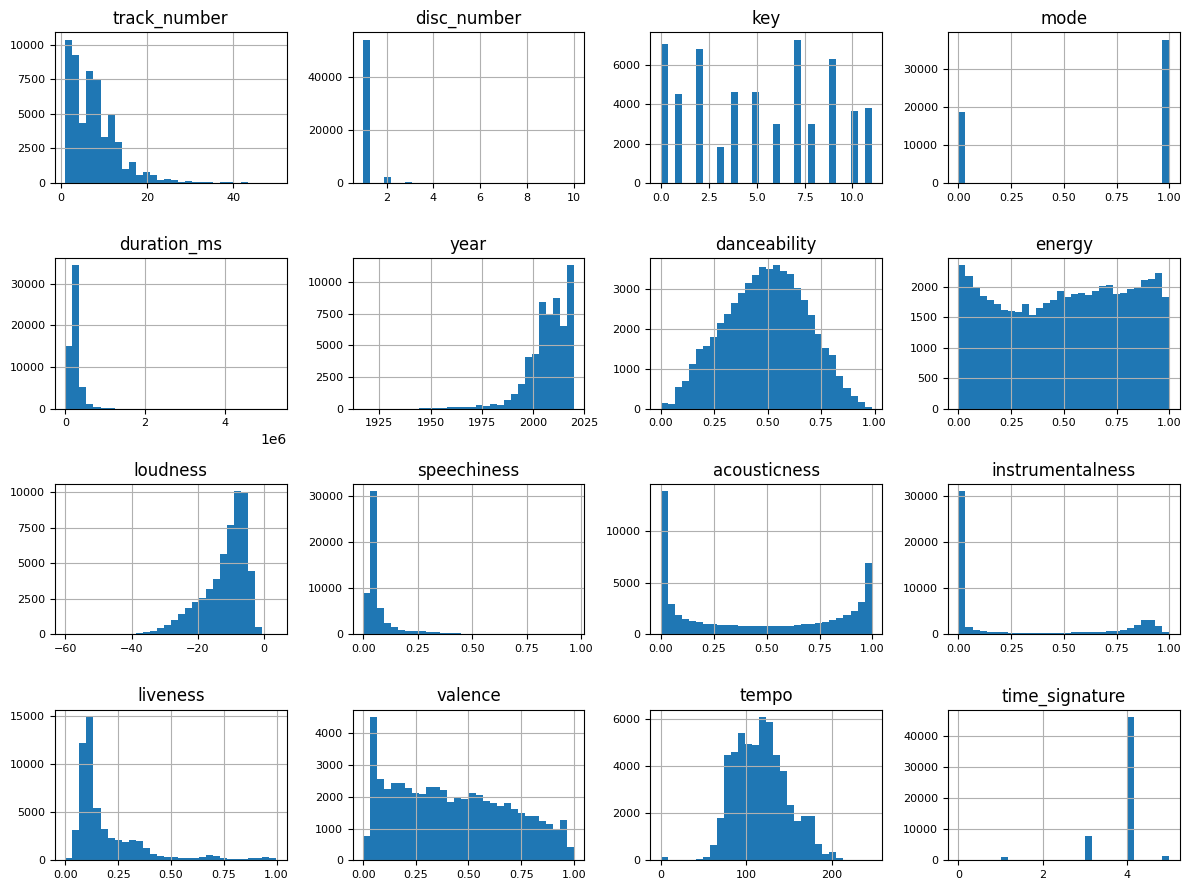

In [9]:
# View the distributions of these features
df_sampled.hist(figsize=(12, 9), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

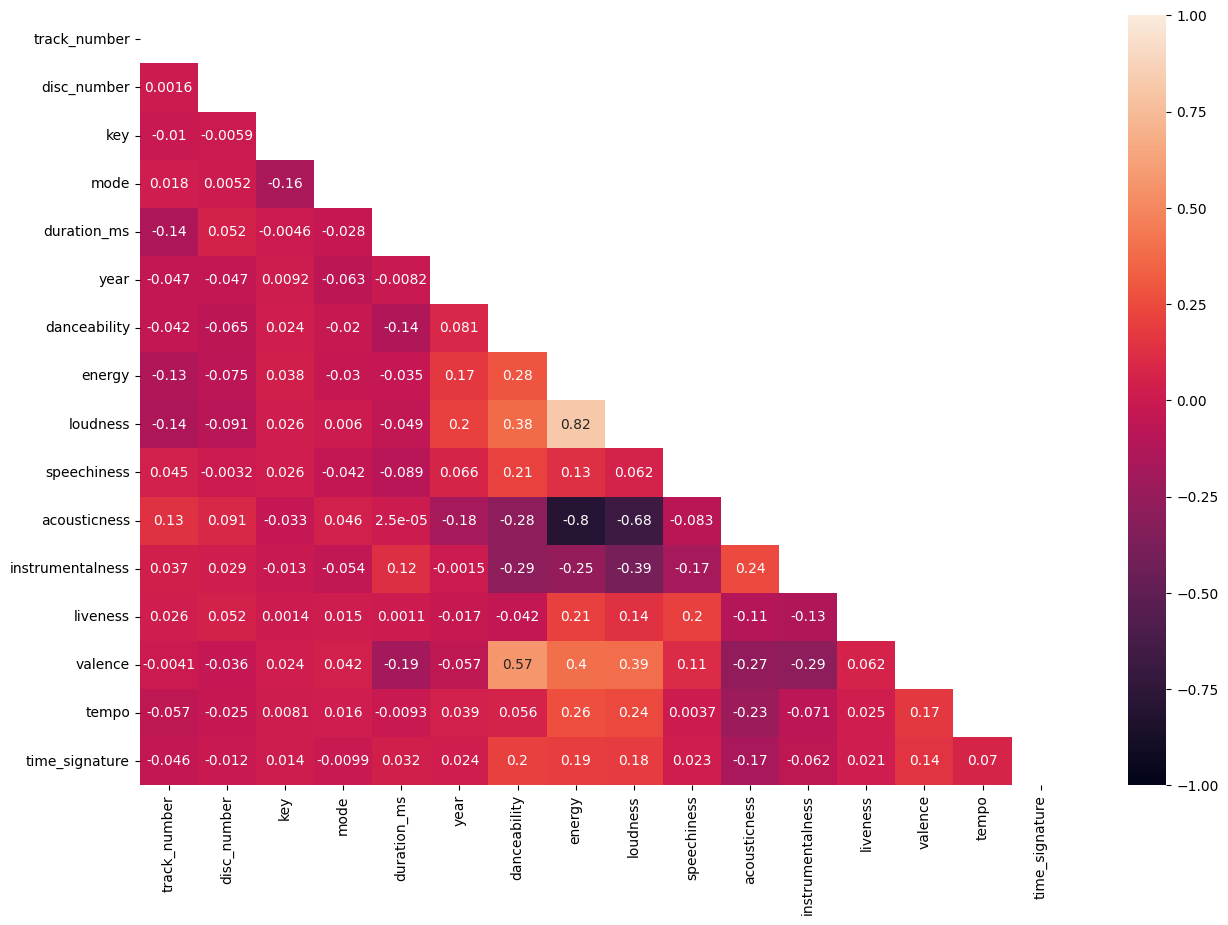

In [10]:
# heatmap for correlation
corr = df_sampled.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # show lower triangle only
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1)
plt.show()

**General Observations**

Columns like `liveness`, `speechiness` experience right-skewed distirbutions. 
`danceability`, `tempo`, and `valence` appear normally distributed.

Looking at this data, it features like `time_signature`, `year`, `key`, and `disc_number` are more categorical in nature and would probably not help in building our recommendation system, so we will drop these features in our pre-processing stage. As for year, we have another qualitative feature called `release_date` not displayed above which can be used instead if we need to factor in recent selections into our recommendation system. 

I'm assuming `track_number` refers to the position of a song within an album and this is also irrelevant for our content based matching system, so we can drop this as well.

Per the heat map, a lot of these categories appear mostly uncorrelated; except for `loudness` and `energy` at first glance being highly correlated at 0.82. 

In [11]:
# Drop the aforementioned columns
df = (df
    .drop("time_signature")
    .drop("year")
    .drop("key")
    .drop("disc_number")
    .drop("track_number")
    .drop("mode")
    )

# Let's trim off all tracks less than a minute or longer than 10mins 
df = df.filter((df.duration_ms >= 60000) & (df.duration_ms < 600000))

nrows, ncols = df.count(), len(df.columns)            
print(f"Data contains {nrows} rows and {ncols} cols")

Data contains 1075167 rows and 18 cols


**Choosing a Model**

Now that we've finished with the preprocessing stage, we want to be able to start recommending songs by searching within a vector space of songs with the most similar features. For efficient querying/searching, we may want some type of approxomite nearest neigbbors (ANN) search. 

Since our data is very extensive and feature-rich with song meta-data, computing similarity across the entire dataset is extremely computationally expensive. We will use Spark's built-in ML library which offers Bucketed Random Project for Euclidean distance, a type of LSH algorithm. This aims to maximize collisions in buckets (where data that is most similar to each other are bucketed), and use this as a model for making recommendations.

To speed up querying even more, we can introduce services like Redis later on to cache the results of common queries...

In [13]:
def train_model(df, feature_cols):
    '''
    Train the model with LSH (bucketed random projection) on the provided numerical features

    args:
    - df 
    - feature_cols: List[str]
    '''
    vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = vector_assembler.transform(df)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    df = scaler.fit(df).transform(df)

    lsh = BucketedRandomProjectionLSH(inputCol="scaled_features", outputCol="hashes", bucketLength=2.0, numHashTables=3)
    lsh_model = lsh.fit(df)
    return lsh_model, df



In [22]:
def recommend_songs(df, model, song_id: str, k=5):
    """
    Use approximate nearest neighbor (ANN) search to retrieve k most-similar songs

    args:
    - df
    - model: LSH model 
    - song_id: input song id
    - k: number of returned tracks
    """
    # Get the features of the given song_id
    query_song = df.filter(col("id") == song_id).select("scaled_features").collect()
    
    if not query_song:
        print("Song ID not found in the dataset.")
        return []

    # Find similar songs
    similar_songs = model.approxNearestNeighbors(df, query_song[0]["scaled_features"], k+1)
    
    # Exclude the input song itself 
    # TODO: add select("id", "name", "artists", "album", "genre") later
    recommendations = similar_songs.filter(col("id") != song_id).collect()
    return recommendations

In [15]:
def find_song(track: str, artist=None):
    '''
    Perform case insensitive search of song name within dataset. Return the entire row
    '''
    track = track.lower()
    
    # Create the filter condition for the song
    filter_condition = lower(col("name")).like(f"%{track}%")
    
    # Add the artist filter if provided
    if artist:
        artist = artist.lower()
        filter_condition &= lower(col("artists")).like(f"%{artist}%")
    
    # Apply the filter and retrieve the results
    result = df.filter(filter_condition)
    
    # Check if any rows are returned, otherwise raise an error
    if result.count() == 0:
        raise ValueError(f"No song found matching '{track}'{' by ' + artist if artist else ''}.")
    
    return result
    

In [16]:
# Test find_song function
test_song = find_song(track="Like a Stone", artist="Audioslave")

In [17]:
# Show entirety of the data from the song search
test_song.show(truncate=False)

+----------------------+------------+----------+----------------------+--------------+--------------------------+--------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+-----------+------------+
|id                    |name        |album     |album_id              |artists       |artist_ids                |explicit|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|release_date|
+----------------------+------------+----------+----------------------+--------------+--------------------------+--------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+-----------+------------+
|3YuaBvuZqcwN3CEAyyoaei|Like a Stone|Audioslave|78guAsers0klWl6RwzgDLd|['Audioslave']|['2ziB7fzrXBoh1HUPS6sVFn']|0       |0.614       |0.568 |-5.477  |0.0276     |0.00797     |0.0             |0.0997  |0.516  |107.849|293960     |2002-11-17  |
+----------------------+

In [ ]:
# Select relevant features for ANN and train the model
features = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
model, df = train_model(df, features)

In [23]:
# Filter the song "Like a Stone" by Audioslave and use model to search for similar recommendations
song_recs = recommend_songs(df, model, song_id="3YuaBvuZqcwN3CEAyyoaei")


In [ ]:
# View the data
for row in song_recs:
    print(row)

Row(id='3ArMREOf4TBqi9hFZGrxfx', name='Eyesight To The Blind', album='The Smithereens Play Tommy (Tribute to The Who)', album_id='5qYunPEmT2VYMRH7N2tnDz', artists="['The Smithereens']", artist_ids="['06KgaEpSluofkcChSo7TNr']", explicit=0, danceability=0.628000020980835, energy=0.5619999766349792, loudness=-5.7270002365112305, speechiness=0.038100000470876694, acousticness=0.04610000178217888, instrumentalness=0.0008640000014565885, liveness=0.10199999809265137, valence=0.5040000081062317, tempo=112.18000030517578, duration_ms=130760, release_date='2009-05-05', features=DenseVector([0.628, 0.562, -5.727, 0.0381, 0.0461, 0.0009, 0.102, 0.504, 112.18]), scaled_features=DenseVector([0.6923, 0.1479, 0.8543, -0.4071, -1.0169, -0.7402, -0.5482, 0.2631, -0.2015]), hashes=[DenseVector([-1.0]), DenseVector([-1.0]), DenseVector([-1.0])], distCol=0.22148891372258286)
Row(id='1nb0kXLSAcbdNeSsH0gLF5', name='Lonely Street', album='Brunswick Lost Soul, Vol. 1', album_id='0QGYVYH5ZQA4ty3XoX9ZLL', artis

In [ ]:
# Save the model and processed dataset
model_path = os.path.join("..", "model")
model.write().overwrite().save(model_path)

data_path = os.path.join("..", "datasets", "processed")
df.write.mode("overwrite").parquet(data_path)